# **Fourier Ptychographic Microscopy:** inference on experimental data

**Purpose:** Comparison of reconstructed experimental data given the learning design from training, conventional multiplexed design, and conventional single LED design.

**author:** Michael Kellman (kellman at berkeley dot edu)

In [30]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import os, sys
import argparse
import time
from datetime import datetime
import scipy.io as sio

import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('image', cmap='bone')

# import local experiment files
sys.path.append('./source/')
import dataloader
import visualizer
import model
from recon import evaluate
from utility import getAbs, getPhase

# Setup device
device_no = 1
torch.cuda.set_device(device_no)
device = torch.device("cuda:"+str(device_no) if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# paths
experimental_data_path = '../../DATA/exp_mc_amp_usaf_2018_11_23/USAF_amplitude_dataset.mat'
training_data_path = '/home/kellman/Workspace/PYTHON/Design_FPM_pytorch/datasets_train_iccp_results/train_amp_exp_n10000.mat' 
ckpt_path = './runs/08:49:07_batch_size=5_stepsize=0.005_loss_fn=abs_optim=adam_num_unrolls=100_alpha=0.100_num_df=4_num_bf=1_num_leds=89/ckpt.tar'

# Load experimental data

Bright Field: 21
Dark Field: 68
Total LEDs: 89


<IPython.core.display.Javascript object>


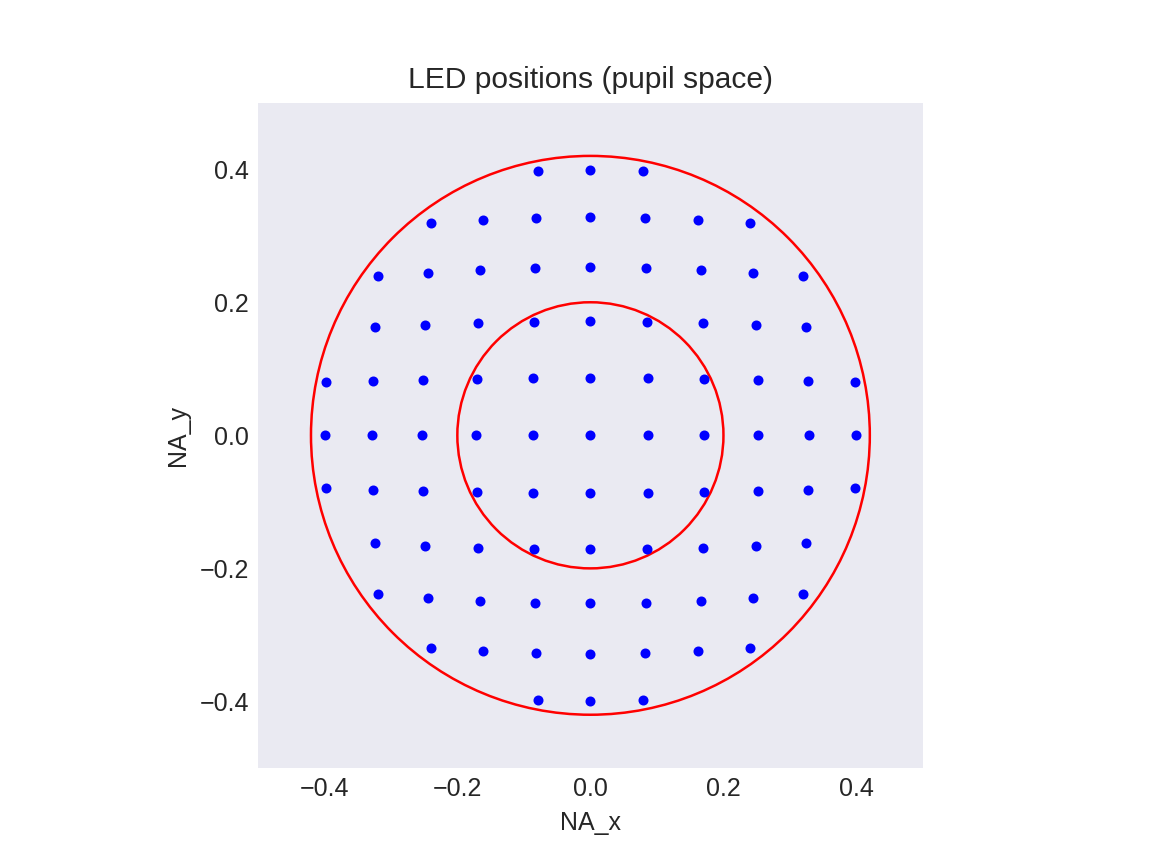

In [18]:
loaddict = sio.loadmat(experimental_data_path)
img_list = loaddict['I']
bg = np.mean(img_list[415:450,70:100,0])

np_dtype = np.float32
img_list = (img_list/bg).astype(np_dtype)

na_list = np.asarray([loaddict['na_y_list'][0],loaddict['na_x_list'][0]]).transpose()
na = loaddict['sys_na'][0][0]
wl = loaddict['wavelength'][0][0]
ps = loaddict['pixel_size'][0][0]
Nleds = na_list.shape[0]

Np = [250,250] # will determine how much to crop out based on upsampling ratio

def dist2(nalist):
    return np.sqrt((nalist[:,0])**2 + (nalist[:,1])**2)
distlist = dist2(na_list)

bfmask = distlist < na
bfleds = na_list[bfmask,:]
Nbfleds = np.sum(bfmask)
print('Bright Field:',np.sum(bfmask))

na_illum = 2.1 * na
dfmask = (distlist < na_illum) & (distlist > na)
dfleds = na_list[dfmask,:]
Ndfleds = np.sum(dfmask)
print('Dark Field:',np.sum(dfmask))

Nleds = Nbfleds + Ndfleds
print('Total LEDs:',Nleds)
pruned_na_list = na_list[:Nleds,:]

fig, ax = plt.subplots()
plt.plot(pruned_na_list[:,0],pruned_na_list[:,1],'b.')
plt.xlabel('NA_x'), plt.ylabel('NA_y'), plt.title('LED positions (pupil space)')
circle1 = plt.Circle((0, 0), na, color=None, edgecolor='r', fill=False)
circle2 = plt.Circle((0, 0), na_illum, color=None, edgecolor='r', fill=False)
ax.add_artist(circle1)
ax.add_artist(circle2)
plt.axis([-0.5,0.5,-0.5,0.5])
ax.set_aspect('equal')

# Setup model metadata

In [19]:
# load dataset and metadata
checkpoint = torch.load(ckpt_path)
dataset = dataloader.dataloader(training_data_path, 1, 1, device)
metadata = dataset.getMetadata()

metadata['Np'] = Np
metadata['num_bf'] = checkpoint['num_bf']
metadata['num_df'] = checkpoint['num_df']
metadata['num_unrolls'] = checkpoint['num_unrolls']
metadata['alpha'] = checkpoint['alpha']
metadata['mag'] *= 2 
network = model.model(metadata, device=device)
print(metadata['ps'], metadata['mag'], metadata['na'])

Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 0.8125
6.5 8 0.2


# Preprocess raw experimental data

In [20]:
# setup measurements
crop = network.grad.crops
scaling = network.grad.scaling

def padMeas(meas,crop):
    padded = np.zeros((meas.shape[0],Np[0],Np[1]))
    cftmp = np.zeros(Np,dtype='complex')
    for ii in range(meas.shape[0]):
        ftmp = np.fft.fftshift(np.fft.fft2(meas[ii,:,:]))
        cftmp[crop[0]:crop[1],crop[2]:crop[3]] = ftmp
        padded[ii,:,:] = np.fft.ifft2(np.fft.ifftshift(cftmp))
    return scaling * padded

Np_meas = img_list.shape[:2]
Nstart = [210-crop[0],180-crop[2]] # whole crop (paper)
crop_list = img_list[Nstart[0] + crop[0]:Nstart[0] + crop[1], Nstart[1] + crop[2]:Nstart[1] + crop[3],:].transpose((2,0,1))
up_img_list = padMeas(crop_list,crop)
experimental_data = up_img_list[:Nleds,:,:]

/home/kellman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


# Visualize raw experimental data

<IPython.core.display.Javascript object>


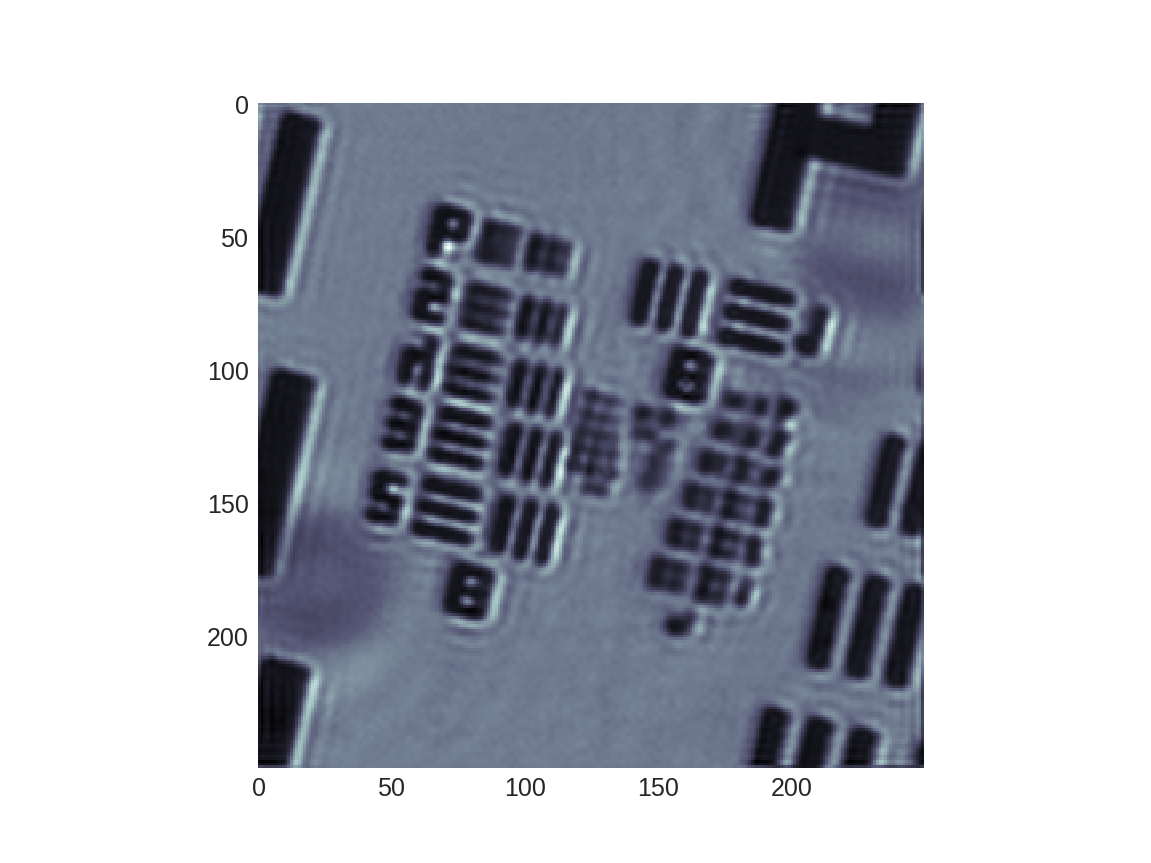

In [22]:
view = lambda x : x[::-1]
plt.figure()
plt.imshow(experimental_data[0,:,:],cmap='bone')

# Physics-based Learned Design Reconstruction

In [23]:
# load trained model checkpoint
checkpoint = torch.load(ckpt_path)

metadata['Np'] = Np
metadata['num_bf'] = checkpoint['num_bf']
metadata['num_df'] = checkpoint['num_df']
metadata['num_unrolls'] = checkpoint['num_unrolls']
metadata['alpha'] = checkpoint['alpha']
metadata['T'] = 4
metadata['mag'] *= 2 # allow for 2x on sideport...
network = model.model(metadata, device=device)

tag = next(reversed(checkpoint['model_state_dict']))
Ctrained = checkpoint['model_state_dict'][tag]
network.grad.C.data = Ctrained.to(device)

Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 0.40625


In [24]:
input_data = torch.unsqueeze(torch.from_numpy(experimental_data.astype(np_dtype)),0)
x0 = network.initialize(input_data.to(device), device=device)
with torch.no_grad():
    x_ld, _ = evaluate(network.network, x0, device = device)

<IPython.core.display.Javascript object>


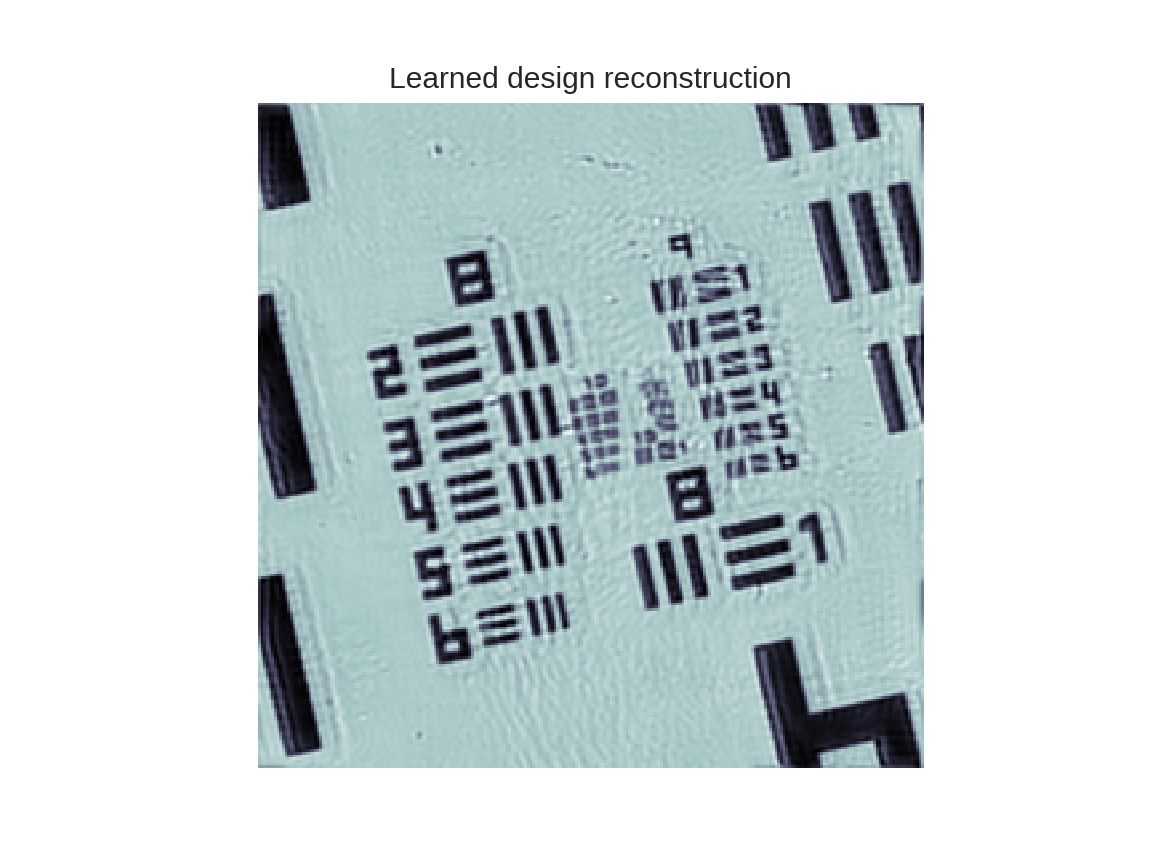

Text(0.5, 1.0, 'Learned design reconstruction')

In [25]:
x_ld_abs = getAbs(x_ld)
x_ld_abs_np = x_ld_abs.cpu().numpy()
view = lambda x : x[::-1]
plt.figure()
plt.imshow(view(x_ld_abs_np),cmap='bone')
plt.axis('off')
plt.title('Learned design reconstruction')

# Single LED Reconstruction

<IPython.core.display.Javascript object>


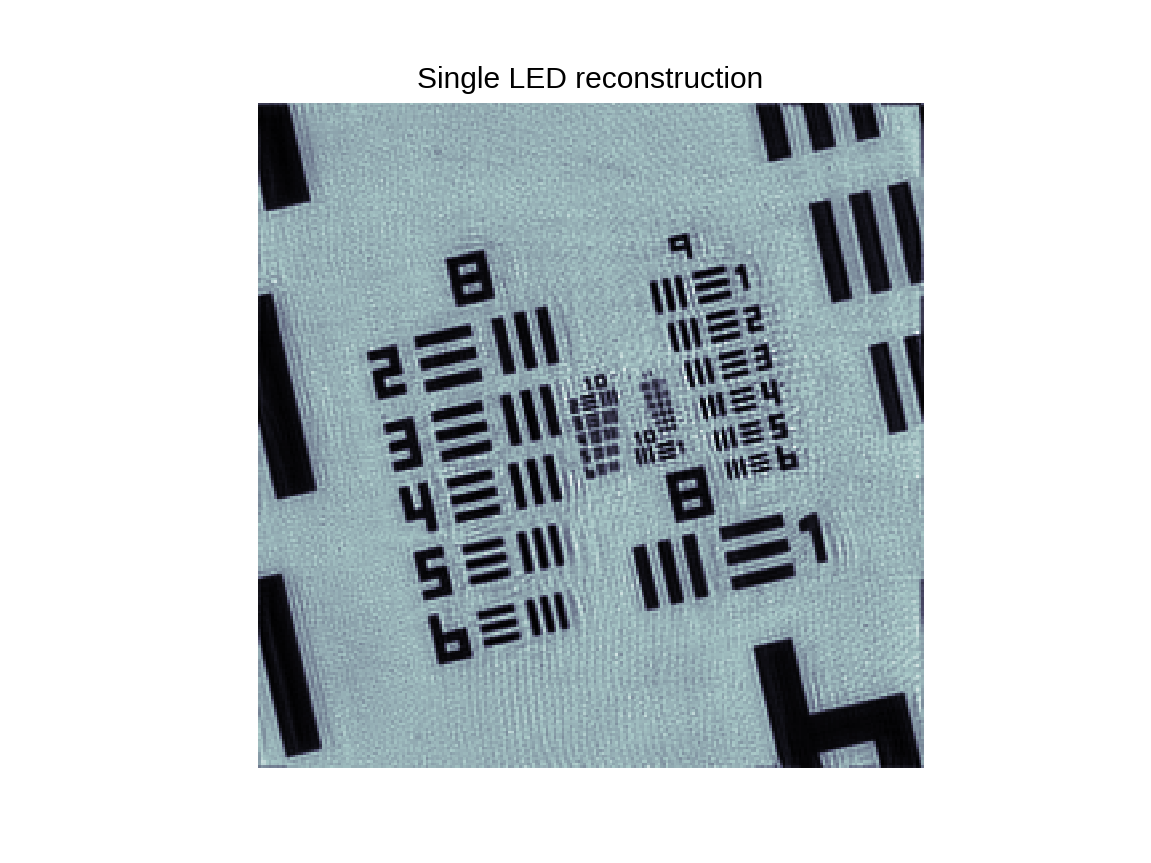

(-0.5, 249.5, 249.5, -0.5)

In [11]:
# just load reconstruction... Takes fucking forever on GPU
x_single = sio.loadmat('./results/full_single_led_reconstruction.mat')['x']
x_single_abs = x_single[...,0]**2 + x_single[...,1]**2
view = lambda x : x[::-1]
plt.figure()
plt.imshow(view(x_single_abs),cmap='bone')
plt.title('Single LED reconstruction')
plt.axis('off')

# Reconstruction Visualization

<IPython.core.display.Javascript object>


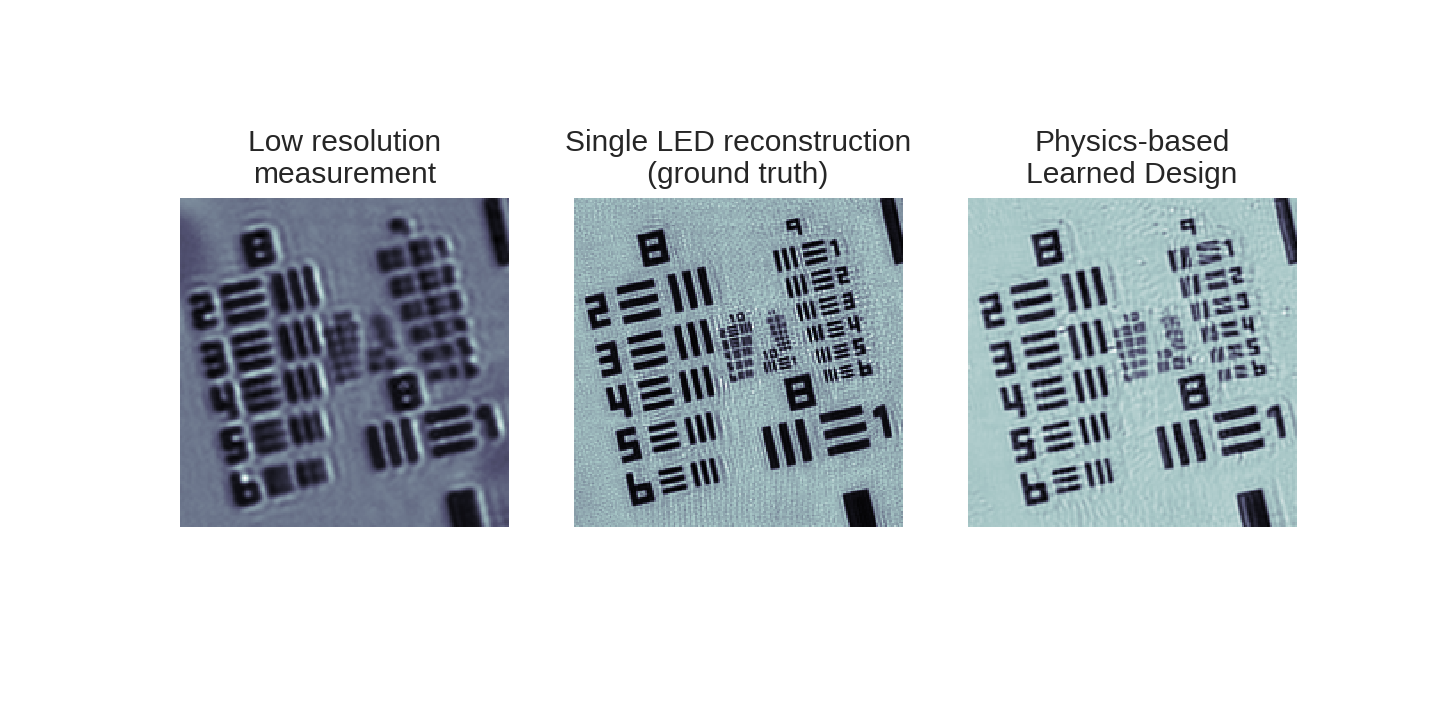

./results/learning_comparison_1_4_100_0.10.pdf


In [12]:
view = lambda x : x[::-1][38:223,35:220]

vmin = np.min(x_single_abs)
vmax = np.max(x_single_abs)

plt.figure(figsize=(8,4))

plt.subplot(131)
img = up_img_list[0,:,:]
scaled_img = img * (np.min(img)/np.max(img))*(vmax/vmin) + vmin
plt.imshow(view(scaled_img))
plt.title('Low resolution\nmeasurement')
plt.axis('off')

plt.subplot(132)
plt.imshow(view(x_single_abs), vmin=vmin, vmax=vmax)
plt.title('Single LED reconstruction\n(ground truth)')
plt.axis('off')

plt.subplot(133)
plt.imshow(view(x_ld_abs_np), vmin=vmin, vmax=vmax)
plt.title('Physics-based\nLearned Design')
plt.axis('off')

exp_output = './results/learning_comparison_{0:d}_{1:d}_{2:d}_{3:.2f}.pdf'.format(checkpoint['num_bf'], checkpoint['num_df'], checkpoint['num_unrolls'], checkpoint['alpha'])
print(exp_output)
plt.savefig(exp_output, dpi=200, transparent=True)

# LED Pattern Visualization

<IPython.core.display.Javascript object>


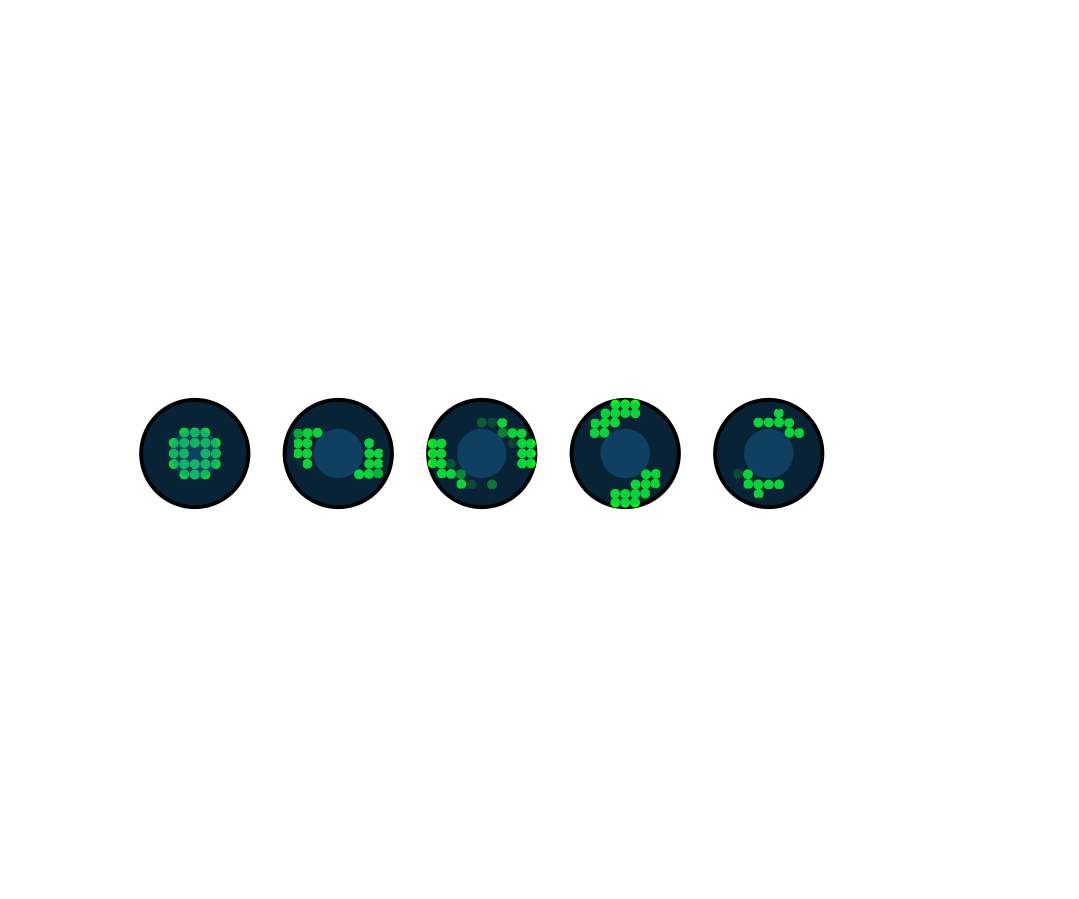

./results/learned_design_1_4_100_0.10.pdf


In [31]:
checkpoint = torch.load(ckpt_path)
tag = next(reversed(checkpoint['model_state_dict']))
Ctrained = checkpoint['model_state_dict'][tag]
visualizer.visualize(Ctrained.cpu().numpy(), metadata)
exp_output = './results/learned_design_{0:d}_{1:d}_{2:d}_{3:.2f}.pdf'.format(checkpoint['num_bf'], checkpoint['num_df'], checkpoint['num_unrolls'], checkpoint['alpha'])
print(exp_output)
plt.savefig(exp_output, dpi=200, transparent=True)